# Modelo de Clusterización
* Modelo enfocado a detectar **posibles clusters** o diferentes grupos de clientes


## Librerias

In [1]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import seaborn as sns # importando seaborn
# Librería para obtener correlación
import scipy.stats as ss
# Librería para obtener todas las combinaciones (c/repetidos) de una lista
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle


from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


## Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
HT_PATH = '/content/drive/MyDrive/Hackaton BBVA/Tablas_guardadas'
VR_PATH = '/content/drive/MyDrive/Reto Vinculación rentable'

#Dejar todo a dos puntos decimales
pd.options.display.float_format = "{:.2f}".format


#Crgar archivo de info
path = HT_PATH + "/otros_fisicas.csv"
df = pd.read_csv(path)
df = df.drop(columns=["Unnamed: 0"])
df.head()

#Mostramos los primeros 10 valores del archivo
df.head(10)

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,EDAD,GENERO,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,ESTADO_CIVIL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,INGRESO_MENSUAL,GRUPO_RIESGO,PERIODO,RIESGO1,RIESGO2,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,FAM_GLOBAL,SALDO_PUNTUAL,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,ABONOS_TDC,CARGOS_TDC,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,HIPOTECARIO_RENT_PROD,LEASING_RENT_PROD,PRESTAMOS_COMERCIALES_RENT_PROD,TARJETAS_RENT_PROD,TJ_EMPRESAS_RENT_PROD,NO_PRODUCTOS_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,PERDIDA_ESPERADA_RENT_PROD_RENT_PROD,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,AUTOS_OTROS,CARTERA_OTROS,COMEXT_OTROS,CONSUMO_OTROS,HIPOTECARIO_OTROS,LEASING_OTROS,PRESTAMOS_COMERCIALES_OTROS,TARJETAS_OTROS,TJ_EMPRESAS_OTROS,NO_PRODUCTOS_OTROS,SALDO_OTROS,ATT,ABANDONO
0,32623893,1,66657047,54,F,2501001,1,C,NO,NO,2376.04,2,202011,2,2,0.00,43.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,4.49,0.16,0.00,0.00,0.11,0.03,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,2296.94,1.00,0.00
1,44400275,1,83381201,59,F,2501001,1,C,NO,NO,2330.46,1,202011,0,0,0.00,11785.02,1272.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,1,0,0.00,0.00,0,0,0,17991.55,799.19,0.00,0.00,563.43,140.86,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,1,9863.86,0.00,0.00
2,87570171,1,84060121,68,F,2501001,1,C,NO,NO,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,8326.98,0.00,0.00
3,87570171,1,84060121,68,F,2501001,1,C,NO,NO,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,14158.59,0.00,0.00
4,43278038,1,76479467,55,M,2501001,1,S,SI,SI,1426.67,1,202011,0,0,0.00,74.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,16.07,0.64,0.00,0.00,0.45,0.11,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,953.05,0.00,0.00
5,68352626,1,24795370,61,M,2501005,1,S,NO,NO,1289.44,2,202011,2,0,0.00,2500.54,0.00,0.00,6666.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,2.50,26.25,0.00,0.00,18.51,4.63,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,60430.20,0.00,0.00
6,68352626,1,24795370,61,M,2501005,1,S,NO,NO,1289.44,2,202011,2,0,0.00,2500.54,0.00,0.00,6666.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,2.50,26.25,0.00,0.00,18.51,4.63,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,5000.25,0.00,0.00
7,39105761,1,27954744,56,M,2501005,1,S,NO,NO,2150.31,1,202011,0,0,0.00,129.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,129.97,5.23,0.00,0.00,3.68,0.92,0.00,0.00,1,0,0,0,0,0,0,1,0,2,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,19457.13,0.00,0.00
8,39105761,1,27954744,56,M,2501005,1,S,NO,NO,2150.31,1,202011,0,0,0.00,129.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00

In [4]:
# Variables categoricas

#df.dtypes

cat = [
"GENERO",
"ESTADO_CIVIL",
"AFILIACION_SMS",
"AFILIACION_BANCA_ONLINE"
]

In [5]:
dummy = pd.get_dummies(df[cat])
dummy

,GENERO_F,GENERO_M,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_O,ESTADO_CIVIL_S,ESTADO_CIVIL_V,AFILIACION_SMS_NO,AFILIACION_SMS_SI,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_SI
0,1,0,1,0,0,0,0,1,0,1,0
1,1,0,1,0,0,0,0,1,0,1,0
2,1,0,1,0,0,0,0,1,0,1,0
3,1,0,1,0,0,0,0,1,0,1,0
4,0,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
435021,1,0,0,0,0,1,0,0,1,0,1
435022,0,1,0,0,0,1,0,0,1,0,1
435023,0,1,0,0,0,1,0,0,1,0,1
435024,0,1,0,0,0,1,0,0,1,0,1


In [6]:
df = df.drop(columns=cat)
df = df.fillna(0)
#df

In [7]:
df = pd.concat([df,dummy], axis=1)
df

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,EDAD,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,INGRESO_MENSUAL,GRUPO_RIESGO,PERIODO,RIESGO1,RIESGO2,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,FAM_GLOBAL,SALDO_PUNTUAL,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,...,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,HIPOTECARIO_RENT_PROD,LEASING_RENT_PROD,PRESTAMOS_COMERCIALES_RENT_PROD,TARJETAS_RENT_PROD,TJ_EMPRESAS_RENT_PROD,NO_PRODUCTOS_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,PERDIDA_ESPERADA_RENT_PROD_RENT_PROD,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,AUTOS_OTROS,CARTERA_OTROS,COMEXT_OTROS,CONSUMO_OTROS,HIPOTECARIO_OTROS,LEASING_OTROS,PRESTAMOS_COMERCIALES_OTROS,TARJETAS_OTROS,TJ_EMPRESAS_OTROS,NO_PRODUCTOS_OTROS,SALDO_OTROS,ATT,ABANDONO,GENERO_F,GENERO_M,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_O,ESTADO_CIVIL_S,ESTADO_CIVIL_V,AFILIACION_SMS_NO,AFILIACION_SMS_SI,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_SI
0,32623893,1,66657047,54,2501001,1,2376.04,2,202011,2,2,0.00,43.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,4.49,0.16,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,2296.94,1.00,0.00,1,0,1,0,0,0,0,1,0,1,0
1,44400275,1,83381201,59,2501001,1,2330.46,1,202011,0,0,0.00,11785.02,1272.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,1,0,0.00,0.00,0,0,0,17991.55,799.19,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,1,9863.86,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
2,87570171,1,84060121,68,2501001,1,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,8326.98,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
3,87570171,1,84060121,68,2501001,1,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,14158.59,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
4,43278038,1,76479467,55,2501001,1,1426.67,1,202011,0,0,0.00,74.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,16.07,0.64,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,953.05,0.00,0.00,0,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435021,36585372,1,20729264,31,701004,3,1843.74,1,202106,0,0,0.00,123.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,207.43,3.87,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,1,273.36,0.00,0.00,1,0,0,0,0,1,0,0,1,0,1
435022,6753303,1,96451056,28,1205005,3,1727.75,2,202106,2,2,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,0.04,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,77117.22,0.50,0.00,0,1,0,0,0,1,0,0,1,0,1
435023,43430648,1,71447688,28,502013,3,1748.67,2,202106,2,2,0.00,396.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [8]:
df.columns

Index(['CODIGO_CLIENTE', 'TIPO_DOCUMENTO', 'NUMERO_DOCUMENTO', 'EDAD',
       'UBIGEO_DIRECCION', 'SEGMENTO_COMERCIAL', 'INGRESO_MENSUAL',
       'GRUPO_RIESGO', 'PERIODO', 'RIESGO1', 'RIESGO2', 'SALDO_MEDIO_VISTA',
       'SALDO_MEDIO_AHORRO', 'SALDO_MEDIO_CTS', 'SALDO_MEDIO_PLAZO',
       'SALDO_MEDIO_FONDO_MUTUO', 'SALDO_MEDIO_AUTOS', 'SALDO_MEDIO_CONSUMO',
       'SALDO_MEDIO_TARJETAS', 'SALDO_MEDIO_HIPOTECARIO',
       'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
       'SALDO_MEDIO_PRESTAMOS_COMERCIALES', 'SALDO_MEDIO_COMEXT',
       'SALDO_MEDIO_TJ_EMPRESAS', 'T_NETCASH', 'T_SEGURO', 'T_WALLET',
       'T_TCAMBIO', 'T_AFILIACION_DIGITAL', 'T_CARGO_RECURRENTE',
       'SALDO_MEDIO_INVERSION_RENTABLE', 'SALDO_MEDIO_CARTERA_ATRASADA',
       'VINCULACION_PN', 'VINCULACION_EMPRESA', 'FAM_GLOBAL', 'SALDO_PUNTUAL',
       'MARGEN_BRUTO', 'EXPOSICION_DEFAULT', 'PERDIDA_ESPERADA',
       'NUMERADOR_RATIO_RENTABILIDAD', 'DENOMINADOR_RATIO_RENTABILIDAD',
       'ABONOS_TDC', 'CARGOS_TDC'

In [9]:
ids_cols = ['CODIGO_CLIENTE']

fis_d = df.describe()
var_con = [x for x in df.columns if x in list(fis_d.columns)+ids_cols]

df = df[var_con]
df

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,EDAD,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,INGRESO_MENSUAL,GRUPO_RIESGO,PERIODO,RIESGO1,RIESGO2,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,FAM_GLOBAL,SALDO_PUNTUAL,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,...,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,HIPOTECARIO_RENT_PROD,LEASING_RENT_PROD,PRESTAMOS_COMERCIALES_RENT_PROD,TARJETAS_RENT_PROD,TJ_EMPRESAS_RENT_PROD,NO_PRODUCTOS_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,PERDIDA_ESPERADA_RENT_PROD_RENT_PROD,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,AUTOS_OTROS,CARTERA_OTROS,COMEXT_OTROS,CONSUMO_OTROS,HIPOTECARIO_OTROS,LEASING_OTROS,PRESTAMOS_COMERCIALES_OTROS,TARJETAS_OTROS,TJ_EMPRESAS_OTROS,NO_PRODUCTOS_OTROS,SALDO_OTROS,ATT,ABANDONO,GENERO_F,GENERO_M,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_O,ESTADO_CIVIL_S,ESTADO_CIVIL_V,AFILIACION_SMS_NO,AFILIACION_SMS_SI,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_SI
0,32623893,1,66657047,54,2501001,1,2376.04,2,202011,2,2,0.00,43.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,4.49,0.16,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,2296.94,1.00,0.00,1,0,1,0,0,0,0,1,0,1,0
1,44400275,1,83381201,59,2501001,1,2330.46,1,202011,0,0,0.00,11785.02,1272.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,1,0,0.00,0.00,0,0,0,17991.55,799.19,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,1,9863.86,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
2,87570171,1,84060121,68,2501001,1,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,8326.98,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
3,87570171,1,84060121,68,2501001,1,1544.58,2,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,2,14158.59,0.00,0.00,1,0,1,0,0,0,0,1,0,1,0
4,43278038,1,76479467,55,2501001,1,1426.67,1,202011,0,0,0.00,74.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,16.07,0.64,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,953.05,0.00,0.00,0,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435021,36585372,1,20729264,31,701004,3,1843.74,1,202106,0,0,0.00,123.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,207.43,3.87,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,1,273.36,0.00,0.00,1,0,0,0,0,1,0,0,1,0,1
435022,6753303,1,96451056,28,1205005,3,1727.75,2,202106,2,2,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00,0,0,0,0.04,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,1,0,0,1,77117.22,0.50,0.00,0,1,0,0,0,1,0,0,1,0,1
435023,43430648,1,71447688,28,502013,3,1748.67,2,202106,2,2,0.00,396.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [10]:
columnas = list(df.columns)

In [11]:
len(columnas)

84

## Correlaciones

In [12]:
umbral_corr = 0.75
alfa = df.corr().melt()
alfa = alfa[(abs(alfa.value) > umbral_corr) & (abs(alfa.value) < 1) ]
alfa
len(alfa)

44

In [13]:
a = list(alfa["variable"])

In [14]:
var_alta_corr = df.loc[:,a]
data1 = var_alta_corr.corr()
data1

,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,GRUPO_RIESGO,RIESGO1,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_PRESTAMOS_COMERCIALES,T_AFILIACION_DIGITAL,T_AFILIACION_DIGITAL,MARGEN_BRUTO,NUMERADOR_RATIO_RENTABILIDAD,TARJETAS_RENT_PROD,NO_PRODUCTOS_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,SALDO_PUNTUAL_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,MARGEN_BRUTO_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD,PERDIDA_ESPERADA_RENT_PROD_RENT_PROD,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,ESTADO_CIVIL_C,ESTADO_CIVIL_S,AFILIACION_SMS_NO,AFILIACION_SMS_NO,AFILIACION_SMS_SI,AFILIACION_SMS_SI,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_NO,AFILIACION_BANCA_ONLINE_SI,AFILIACION_BANCA_ONLINE_SI,AFILIACION_BANCA_ONLINE_SI
TIPO_DOCUMENTO,1.00,0.83,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.01,-0.01,0.01,0.01,0.01,-0.01,-0.01,-0.01
NUMERO_DOCUMENTO,0.83,1.00,-0.01,-0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,0.01,0.01,0.01,-0.01,-0.01,-0.01
GRUPO_RIESGO,-0.01,-0.01,1.00,0.80,-0.00,-0.00,-0.00,-0.00,0.03,0.03,-0.02,-0.03,-0.02,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.01,-0.01,0.02,-0.02,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.03,-0.03,0.03,0.03,-0.03,-0.03,-0.03,0.03,0.03,0.03
RIESGO1,-0.00,-0.00,0.80,1.00,-0.01,-0.01,-0.01,-0.01,0.05,0.05,-0.03,-0.04,-0.06,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,0.02,-0.02,-0.00,-0.00,-0.00,-0.00,-0.04,0.04,-0.04,-0.04,0.04,0.04,-0.04,-0.04,-0.04,0.04,0.04,0.04
SALDO_MEDIO_PRESTAMOS_COMERCIALES,-0.00,0.00,-0.00,-0.01,1.00,1.00,1.00,1.00,-0.00,-0.00,0.08,0.01,-0.00,0.02,0.83,0.83,0.83,0.83,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.38,-0.06,0.80,0.80,0.80,0.80,0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
SALDO_MEDIO_PRESTAMOS_COMERCIALES,-0.00,0.00,-0.00,-0.01,1.00,1.00,1.00,1.00,-0.00,-0.00,0.08,0.01,-0.00,0.02,0.83,0.83,0.83,0.83,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.38,-0.06,0.80,0.80,0.80,0.80,0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
SALDO_MEDIO_PRESTAMOS_COMERCIALES,-0.00,0.00,-0.00,-0.01,1.00,1.00,1.00,1.00,-0.00,-0.00,0.08,0.01,-0.00,0.02,0.83,0.83,0.83,0.83,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.38,-0.06,0.80,0.80,0.80,0.80,0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
SALDO_MEDIO_PRESTAMOS_COMERCIALES,-0.00,0.00,-0.00,-0.01,1.00,1.00,1.00,1.00,-0.00,-0.00,0.08,0.01,-0.00,0.02,0.83,0.83,0.83,0.83,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.38,-0.06,0.80,0.80,0.80,0.80,0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
T_AFILIACION_DIGITAL,-0.01,-0.01,0.03,0.05,-0.00,-0.00,-0.00,-0.00,1.00,1.00,0.03,0.02,0.03,0.04,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.06,0.07,-0.64,-0.64,0.64,0.64,-0.86,-0.86,-0.86,0.86,0.86,0.86
T_AFILIACION_DIGITAL,-0.01,-0.01,0.03,0.05,-0.00,-0.00,-0.00,-0.00,1.00,1.00,0.03,0.02,0.03,0.04,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.06,0.07,-0.64,-0.64,0.64,0.64,-0.86,-0.86,-0.86,0.86,0.86,0.86


In [15]:
data1.shape

(44, 44)

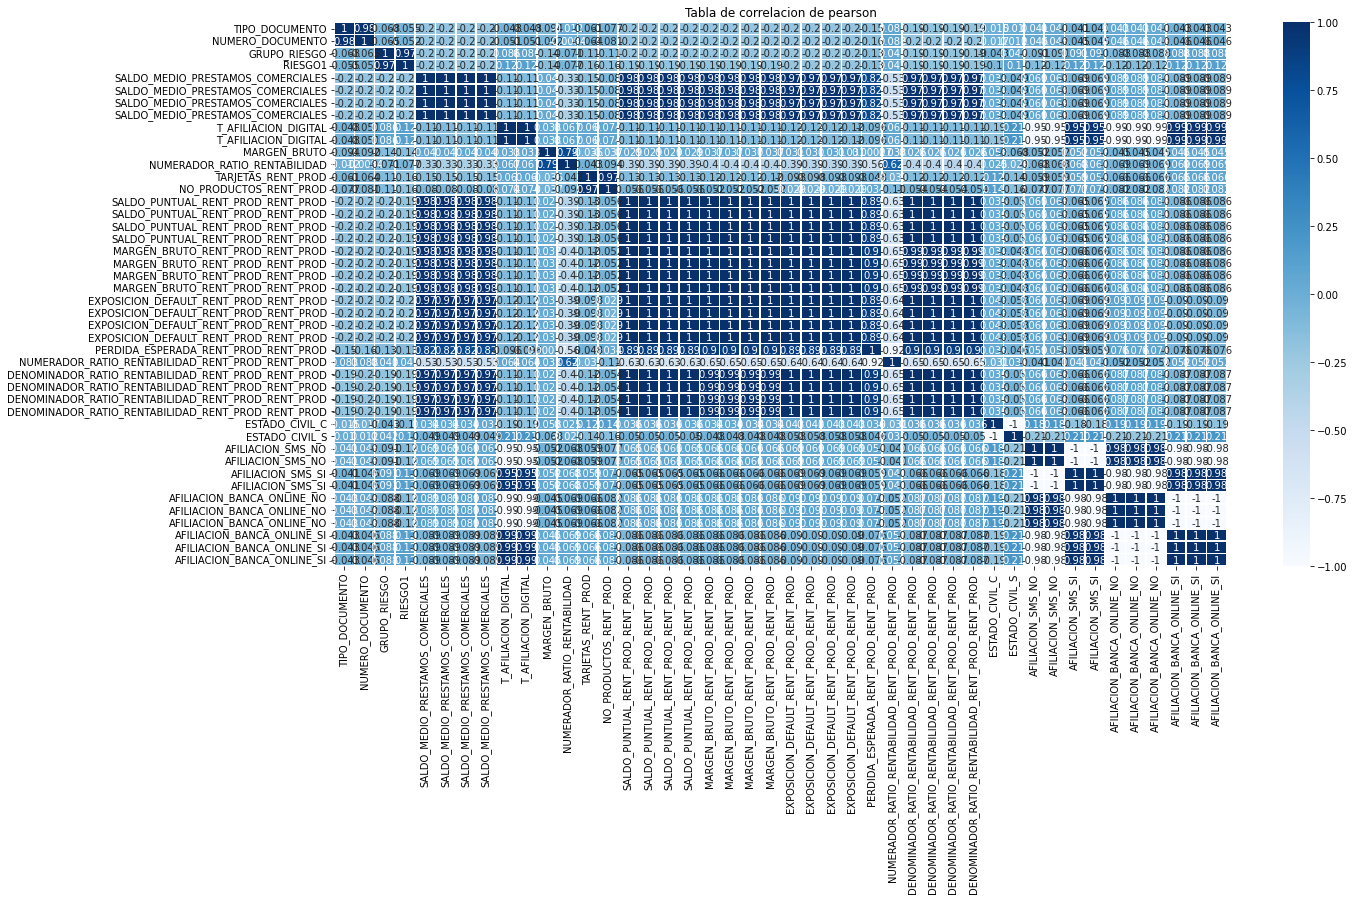

<Figure size 432x288 with 0 Axes>

In [17]:

corr = data1.corr("pearson")
plt.figure(figsize=(20, 10))
sns.heatmap(corr, xticklabels = corr.columns.values,yticklabels = corr.columns.values\
            ,annot = True,linewidths = .6, cmap="Blues")
plt.title("Tabla de correlacion de " + "pearson")
plt.show()
plt.clf()

In [18]:
# Creamos una matriz de Coorelación positiva
data2 = df.corr().abs()

# Creamos una mascara booleana
mask = np.triu(np.ones_like(data2, dtype=bool))
tri_df = data2.mask(mask)
tri_df

# Lista to drop

to_drop = [c for c in tri_df.columns if any (tri_df[c] > umbral_corr)]
to_drop

['TIPO_DOCUMENTO',
 'GRUPO_RIESGO',
 'SALDO_MEDIO_PRESTAMOS_COMERCIALES',
 'T_AFILIACION_DIGITAL',
 'MARGEN_BRUTO',
 'TARJETAS_RENT_PROD',
 'SALDO_PUNTUAL_RENT_PROD_RENT_PROD',
 'MARGEN_BRUTO_RENT_PROD_RENT_PROD',
 'EXPOSICION_DEFAULT_RENT_PROD_RENT_PROD',
 'PERDIDA_ESPERADA_RENT_PROD_RENT_PROD',
 'GENERO_F',
 'ESTADO_CIVIL_C',
 'AFILIACION_SMS_NO',
 'AFILIACION_SMS_SI',
 'AFILIACION_BANCA_ONLINE_NO']

In [19]:
# Borrar var correlacionadas del DF
df = df.drop(to_drop, axis=1)
df

,CODIGO_CLIENTE,NUMERO_DOCUMENTO,EDAD,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,INGRESO_MENSUAL,PERIODO,RIESGO1,RIESGO2,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,FAM_GLOBAL,SALDO_PUNTUAL,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,ABONOS_TDC,CARGOS_TDC,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,HIPOTECARIO_RENT_PROD,LEASING_RENT_PROD,PRESTAMOS_COMERCIALES_RENT_PROD,TJ_EMPRESAS_RENT_PROD,NO_PRODUCTOS_RENT_PROD,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,AUTOS_OTROS,CARTERA_OTROS,COMEXT_OTROS,CONSUMO_OTROS,HIPOTECARIO_OTROS,LEASING_OTROS,PRESTAMOS_COMERCIALES_OTROS,TARJETAS_OTROS,TJ_EMPRESAS_OTROS,NO_PRODUCTOS_OTROS,SALDO_OTROS,ATT,ABANDONO,GENERO_M,ESTADO_CIVIL_D,ESTADO_CIVIL_O,ESTADO_CIVIL_S,ESTADO_CIVIL_V,AFILIACION_BANCA_ONLINE_SI
0,32623893,66657047,54,2501001,1,2376.04,202011,2,2,0.00,43.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,4.49,0.00,0.00,0.11,0.03,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,1,0,0,1,2296.94,1.00,0.00,0,0,0,0,0,0
1,44400275,83381201,59,2501001,1,2330.46,202011,0,0,0.00,11785.02,1272.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0.00,0.00,0,0,0,17991.55,0.00,0.00,563.43,140.86,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,1,0,1,9863.86,0.00,0.00,0,0,0,0,0,0
2,87570171,84060121,68,2501001,1,1544.58,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,1,0,0,0,1,0,2,8326.98,0.00,0.00,0,0,0,0,0,0
3,87570171,84060121,68,2501001,1,1544.58,202011,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,1,0,0,0,1,0,2,14158.59,0.00,0.00,0,0,0,0,0,0
4,43278038,76479467,55,2501001,1,1426.67,202011,0,0,0.00,74.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,16.07,0.00,0.00,0.45,0.11,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,1,0,0,1,953.05,0.00,0.00,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435021,36585372,20729264,31,701004,3,1843.74,202106,0,0,0.00,123.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,207.43,0.00,0.00,-9.32,0.67,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,1,0,1,273.36,0.00,0.00,0,0,0,1,0,1
435022,6753303,96451056,28,1205005,3,1727.75,202106,2,2,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,0.04,0.00,0.00,-3.94,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,1,0,0,1,77117.22,0.50,0.00,1,0,0,1,0,1
435023,43430648,71447688,28,502013,3,1748.67,202106,2,2,0.00,396.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0,781.03,0.00,0.00,62.94,20.68,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,1,0,0,1,142299.99,0.50,0.00,1,0,0,1,0,1
435024,41968675,82674577,28,101036,3,5447.67,202106,0,0,0.00,2226.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0.00,0.00,0,0,1,4269.32,0.00,0.00,79.85,25.21,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,1,0,0,1,0,0,2,14052.93,0.33,0.00,1,0,0,1,0,1


In [20]:
# # Calcular correlación de Variables
# # ----------------------------------------------- Correlación de Pearson -----------------------------------------------
# tabla_corr = data


# def correlacion(method = ["pearson","spearman","kendall"]):
  
#   numericas=['CODIGO_CLIENTE', 'TIPO_DOCUMENTO', 'NUMERO_DOCUMENTO', 'EDAD',
#       'UBIGEO_DIRECCION', 'SEGMENTO_COMERCIAL', 'INGRESO_MENSUAL',
#       'GRUPO_RIESGO', 'PERIODO', 'RIESGO1', 'RIESGO2', 'RIESGO3',
#       'SALDO_MEDIO_VISTA', 'SALDO_MEDIO_AHORRO', 'SALDO_MEDIO_CTS',
#       'SALDO_MEDIO_PLAZO', 'SALDO_MEDIO_FONDO_MUTUO', 'SALDO_MEDIO_AUTOS',
#       'SALDO_MEDIO_CONSUMO', 'SALDO_MEDIO_TARJETAS',
#       'SALDO_MEDIO_HIPOTECARIO', 'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
#       'SALDO_MEDIO_PRESTAMOS_COMERCIALES', 'SALDO_MEDIO_COMEXT',
#       'SALDO_MEDIO_TJ_EMPRESAS', 'FAM_COBRANZAS', 'FAM_COMEX',
#       'FAM_PAGOHABERES', 'FAM_PROVEEDORES', 'FAM_SUPPLY', 'FAM_VISANET',
#       'T_NETCASH', 'T_SEGURO', 'T_WALLET', 'T_TCAMBIO',
#       'T_AFILIACION_DIGITAL', 'T_CARGO_RECURRENTE',
#       'SALDO_MEDIO_INVERSION_RENTABLE', 'SALDO_MEDIO_CARTERA_ATRASADA',
#       'VINCULACION_PN', 'VINCULACION_EMPRESA', 'SALDO_PUNTUAL',
#       'MARGEN_FINANCIERO', 'COMISIONES', 'MARGEN_BRUTO', 'EXPOSICION_DEFAULT',
#       'PERDIDA_ESPERADA', 'NUMERADOR_RATIO_RENTABILIDAD',
#       'DENOMINADOR_RATIO_RENTABILIDAD']

#   print('-------------------------------------------- VARIABLES NUMERICAS-------------------------------------------------------')

#   var_num = numericas
#   cont = 1
  
  
  
#   for var in var_num:
#       tabla_corr[var]=tabla_corr[var].astype(float)

#   corr = tabla_corr.corr(method)
#   plt.figure(figsize=(20, 10))
#   sns.heatmap(corr, xticklabels = corr.columns.values,yticklabels = corr.columns.values\
#               ,annot = True,linewidths = .6, cmap="Blues")
#   plt.title("Tabla de correlacion de " + method)
#   plt.show()
#   plt.clf()


In [21]:
df.columns

Index(['CODIGO_CLIENTE', 'NUMERO_DOCUMENTO', 'EDAD', 'UBIGEO_DIRECCION',
       'SEGMENTO_COMERCIAL', 'INGRESO_MENSUAL', 'PERIODO', 'RIESGO1',
       'RIESGO2', 'SALDO_MEDIO_VISTA', 'SALDO_MEDIO_AHORRO', 'SALDO_MEDIO_CTS',
       'SALDO_MEDIO_PLAZO', 'SALDO_MEDIO_FONDO_MUTUO', 'SALDO_MEDIO_AUTOS',
       'SALDO_MEDIO_CONSUMO', 'SALDO_MEDIO_TARJETAS',
       'SALDO_MEDIO_HIPOTECARIO', 'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
       'SALDO_MEDIO_COMEXT', 'SALDO_MEDIO_TJ_EMPRESAS', 'T_NETCASH',
       'T_SEGURO', 'T_WALLET', 'T_TCAMBIO', 'T_CARGO_RECURRENTE',
       'SALDO_MEDIO_INVERSION_RENTABLE', 'SALDO_MEDIO_CARTERA_ATRASADA',
       'VINCULACION_PN', 'VINCULACION_EMPRESA', 'FAM_GLOBAL', 'SALDO_PUNTUAL',
       'EXPOSICION_DEFAULT', 'PERDIDA_ESPERADA',
       'NUMERADOR_RATIO_RENTABILIDAD', 'DENOMINADOR_RATIO_RENTABILIDAD',
       'ABONOS_TDC', 'CARGOS_TDC', 'AUTOS_RENT_PROD', 'CARTERA_RENT_PROD',
       'COMEXT_RENT_PROD', 'CONSUMO_RENT_PROD', 'HIPOTECARIO_RENT_PROD',
       'LE

## EDA

In [22]:
#INTERACTIVA
#Crreación función con un for que recorra todas las variables numerocas del df y nos muestre su histograma, percentiles y datos relevantes

@interact
def stats_vars(bins = [10,20,30,40,50,60,70,80,90,100],
               facecolor = ['grey','lightblue','orange','green','red']
              ):
    
     # Lista de variables numericas
    numericas=['CODIGO_CLIENTE', 'TIPO_DOCUMENTO', 'NUMERO_DOCUMENTO', 'EDAD',
       'UBIGEO_DIRECCION', 'SEGMENTO_COMERCIAL', 'INGRESO_MENSUAL',
       'GRUPO_RIESGO', 'PERIODO', 'RIESGO1', 'RIESGO2', 'RIESGO3',
       'SALDO_MEDIO_VISTA', 'SALDO_MEDIO_AHORRO', 'SALDO_MEDIO_CTS',
       'SALDO_MEDIO_PLAZO', 'SALDO_MEDIO_FONDO_MUTUO', 'SALDO_MEDIO_AUTOS',
       'SALDO_MEDIO_CONSUMO', 'SALDO_MEDIO_TARJETAS',
       'SALDO_MEDIO_HIPOTECARIO', 'SALDO_MEDIO_CARTERA', 'SALDO_MEDIO_LEASING',
       'SALDO_MEDIO_PRESTAMOS_COMERCIALES', 'SALDO_MEDIO_COMEXT',
       'SALDO_MEDIO_TJ_EMPRESAS', 'FAM_COBRANZAS', 'FAM_COMEX',
       'FAM_PAGOHABERES', 'FAM_PROVEEDORES', 'FAM_SUPPLY', 'FAM_VISANET',
       'T_NETCASH', 'T_SEGURO', 'T_WALLET', 'T_TCAMBIO',
       'T_AFILIACION_DIGITAL', 'T_CARGO_RECURRENTE',
       'SALDO_MEDIO_INVERSION_RENTABLE', 'SALDO_MEDIO_CARTERA_ATRASADA',
       'VINCULACION_PN', 'VINCULACION_EMPRESA', 'SALDO_PUNTUAL',
       'MARGEN_FINANCIERO', 'COMISIONES', 'MARGEN_BRUTO', 'EXPOSICION_DEFAULT',
       'PERDIDA_ESPERADA', 'NUMERADOR_RATIO_RENTABILIDAD',
       'DENOMINADOR_RATIO_RENTABILIDAD', 'RATIO_RENTABILIDAD']

    print('-------------------------------------------- VARIABLES NUMERICAS-------------------------------------------------------')

    var_num = df.columns
    cont = 1
    
    for c in var_num:
        print('\n///////////////////////////////////////',cont,")",c,'////////////////////////////////////////////////////////////')
        df[c] = df[c].astype(float)
            #N° de vacíos
        print('N° nulos:', df.loc[df[c].isna()==True].shape[0])
        # contar el número de categorías únicas
        num_cat = len(df[c].unique())
        cont += 1
        print('N° de valores distintos:', num_cat)

        # Mostrar dataframe con los valores
        g_aux = 100*df[c].value_counts(normalize=True).to_frame().head(10)
        g_aux.rename(columns={c : 'Porcentaje'}, inplace=True)
        g_aux.reset_index(inplace=True)
        g_aux.rename(columns={'index' : c}, inplace=True)
        display(g_aux)

        df[c].plot(kind='hist', bins= bins, figsize=(12,6), facecolor= facecolor,edgecolor='black')
        #plt.figure(figsize=(30, 10))
        #plt.hist(df[c], bins=20)
        display(df[c].describe())
        deciles = np.arange(1, 10) * 10
        deciles_dist = [np.percentile(df[c], dec) for dec in deciles]
        print('percentiles ' + str(deciles_dist))
        plt.show()

interactive(children=(Dropdown(description='bins', options=(10, 20, 30, 40, 50, 60, 70, 80, 90, 100), value=10…

## Normalización

In [23]:
df.shape

(435026, 69)

In [24]:
df.shape[1]

69

In [25]:
# Definir variables de entrada
X = df.iloc[:,0:df.shape[1]].values 
X

array([[3.2623893e+07, 6.6657047e+07, 5.4000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.4400275e+07, 8.3381201e+07, 5.9000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.7570171e+07, 8.4060121e+07, 6.8000000e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.3430648e+07, 7.1447688e+07, 2.8000000e+01, ..., 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.1968675e+07, 8.2674577e+07, 2.8000000e+01, ..., 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.1968675e+07, 8.2674577e+07, 2.8000000e+01, ..., 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00]])

In [26]:

# Aplicar Normalización: Standard Scaler

# Creamos el Objeto de Escalamiento
std_scaler = StandardScaler()

# aplicamos fit y transform a la data 
X_std = std_scaler.fit_transform(X)

X_std

array([[-0.60501635,  0.31865973,  0.84529979, ..., -1.59990273,
        -0.09024111, -1.20493115],
       [-0.19543196,  0.64491208,  1.23207704, ..., -1.59990273,
        -0.09024111, -1.20493115],
       [ 1.30602372,  0.65815635,  1.92827609, ..., -1.59990273,
        -0.09024111, -1.20493115],
       ...,
       [-0.22915574,  0.41211486, -1.1659419 , ...,  0.625038  ,
        -0.09024111,  0.82992294],
       [-0.28000338,  0.63112736, -1.1659419 , ...,  0.625038  ,
        -0.09024111,  0.82992294],
       [-0.28000338,  0.63112736, -1.1659419 , ...,  0.625038  ,
        -0.09024111,  0.82992294]])

## Método del Codo

In [27]:
X = X_std

In [28]:
max_k = 10    ## maximo número de clusters que vamos a crear


K = range(1,max_k+1)
ssw = []

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)

    centers = pd.DataFrame(kmeanModel.cluster_centers_)
    labels = kmeanModel.labels_
    
    ssw_k = sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1))
    ssw.append(ssw_k)
    print(k)
    print(ssw_k)
    print(ssw)
    



1
2495292.984867203
[2495292.984867203]
2
2420455.7508521397
[2495292.984867203, 2420455.7508521397]
3
2480596.537875713
[2495292.984867203, 2420455.7508521397, 2480596.537875713]
4
2409456.0814245255
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255]
5
2339848.4857598436
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255, 2339848.4857598436]
6
2300013.100995534
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255, 2339848.4857598436, 2300013.100995534]
7
2266694.390800365
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255, 2339848.4857598436, 2300013.100995534, 2266694.390800365]
8
2290357.754062485
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255, 2339848.4857598436, 2300013.100995534, 2266694.390800365, 2290357.754062485]
9
2258996.347838005
[2495292.984867203, 2420455.7508521397, 2480596.537875713, 2409456.0814245255, 2339848.4857598436, 2300013.10

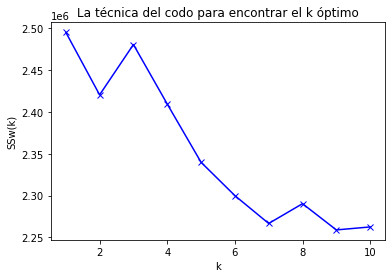

In [29]:
#Representación del codo
plt.plot(K, ssw, "bx-")
plt.xlabel("k")
plt.ylabel("SSw(k)")
plt.title("La técnica del codo para encontrar el k óptimo")
plt.show()

## Clusters

In [ ]:
# alfa = data.corr().melt()
# alfa = alfa[(abs(alfa.value) > 0.7) & (abs(alfa.value) < 1) ]
# cols = data.columns
# variables_corr = [i for i in cols if i not in alfa.variable]
# data1 = data[variables_corr]
# data1 = data1.corr()
# data1

In [30]:
kmeanModel = KMeans(n_clusters=6).fit(X)

centers = pd.DataFrame(kmeanModel.cluster_centers_)
labels = kmeanModel.labels_
df["labels"] = labels


In [31]:
beta = df.groupby(["labels"]).mean()
beta = beta[["EDAD", "SALDO_MEDIO_VISTA", "SALDO_MEDIO_AUTOS", "SALDO_MEDIO_TARJETAS", "HIPOTECARIO_RENT_PROD", 
             "AUTOS_RENT_PROD", "CARTERA_RENT_PROD", "COMEXT_RENT_PROD", "CONSUMO_RENT_PROD", "LEASING_RENT_PROD",
             "NO_PRODUCTOS_RENT_PROD", "FAM_GLOBAL","NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD", "DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD",
             "ABANDONO","ATT","VINCULACION_PN"]]
beta

,EDAD,SALDO_MEDIO_VISTA,SALDO_MEDIO_AUTOS,SALDO_MEDIO_TARJETAS,HIPOTECARIO_RENT_PROD,AUTOS_RENT_PROD,CARTERA_RENT_PROD,COMEXT_RENT_PROD,CONSUMO_RENT_PROD,LEASING_RENT_PROD,NO_PRODUCTOS_RENT_PROD,FAM_GLOBAL,NUMERADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,DENOMINADOR_RATIO_RENTABILIDAD_RENT_PROD_RENT_PROD,ABANDONO,ATT,VINCULACION_PN
labels,,,,,,,,,,,,,,,,,
0,39.00,1.91,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,-0.26,0.03,0.04,0.36,0.00
1,47.22,161.88,0.00,0.46,0.01,0.01,0.00,0.00,0.06,0.00,0.26,0.08,-5.65,5.27,0.03,0.16,0.65
2,44.91,25.83,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.02,-11.61,0.12,0.01,0.18,0.00
3,44.87,14.00,0.58,1.75,0.06,0.05,0.00,0.00,0.89,0.00,1.33,0.01,-61.60,37.81,0.02,0.11,0.03
4,45.01,4.83,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,-1.06,0.08,0.00,0.02,0.00
5,52.99,0.00,0.00,0.80,0.43,0.17,0.00,0.00,0.23,0.00,1.70,0.08,-25557.69,22361.25,0.00,0.13,0.04


**Grupo 0: Jovenes**
*Alta Transaccionalidad y Costosos al Banco*

* Tienen auto
* Pocos Productos
* Saldo medio en tajetas
* Son rentables
* Abandono maximo de un mes
* Transaccionalidad alta
* No son deudores
* Poco vinciulados

**Grupo 1: Estrella**
*Muy vinculados y con alta transaccionalodad*
 
* Alto Saldo Medio
* Tienen Auto
* Tienen más productos hipotecarios
* Rentabilidad alta para el banco
* Alta inversion de parte del banco
* Uso constante de servicos del banco
* Altamente Vinculados

**Grupo 2: Totaleros**
*No usan tanto sus productos y no les gusta deber*

* Poco Saldo Medio a la Vista
* Tienen Auto
* No les gusta deber
* Rentabilidad media
* Tienen pocos productos con el banco
* Desatencion Alta

**Grupo 3: Potenciales**
*Muchos productos y poca liquidez*

* Saldo Medio a la Vista Comun 
* Tienen auto
* Usan de tarjetas
* Mayor numero de productos
* Tardan en pagar
* Rentabilidad media
* Desatención alta

**Grupo 4: De Oportunidad**
*Usan sus tarjetas en promociones y deudores*

* Poco saldo medio
* Tienen Auto
* Deben tarjetas
* No tardan en pagar
* Tienen mal ratio de rentabilidad
* Periodos de maximo un mes de inactividad
* Alta vinculación

**Grupo 5: Desatendido**
*Clientes con mayor edad y con poca atención al banco*

* Son los de mayor de edad
* Tienen pocos productos
* Pobre vinculacion
* Pobre ratio de rentabilidad
* No dejan dinero en su cuenta 


In [32]:
# Guardado 
beta.to_csv(HT_PATH + "/bbva_fisicas_no_bbva_mean.csv")
df.to_csv(HT_PATH + "/bbva_fisicas_no_bbva_cl.csv")

In [33]:
# Pickle
pkl_filename = HT_PATH + "/fisicas_no_bbva_pickle.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeanModel, file)

In [ ]:

# def grafica(tresD = [True, False],
#            opacidad = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
#             tamaño = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200],
#             marca = ["o",".",",","v","^","<",">","1","2","3","4","8","s","p","*","H","h","+","X","x","D","d","|","_"],
#             colores = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'],
#             a = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
#             b = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
#            ):
  
#   plt.figure(figsize = (16, 9))
  
#   if tresD == True:

#     color_list = data["target"]
#     color_mapping = {'ALTO': 2, 'MEDIO': 1, 'BAJO':0}  
#     color_indicator = [color_mapping[color] if color in color_mapping else 'na' for color in color_list]
#     ax = plt.axes(projection ="3d")     
#     ax.scatter3D(x, y, z, c = color_indicator, s = tamaño, marker = marca, alpha = opacidad, cmap = colores)
#     ax.view_init(a, b)
#     ax.set_zlabel('Z')
      
#   else:
#     # color_list = data["target"]
#     # color_mapping = {'ALTO': 2, 'MEDIO': 1, 'BAJO':0}  
#     #color_indicator = [color_mapping[color] if color in color_mapping else 'na' for color in color_list]
#     colors = np.array(["black", "green"]
#     plt.scatter(data["principal component 1"], data["principal component 2"], c = colors[data["target"].values], 
#                 s = tamaño, marker = marca, alpha = opacidad,cmap = colores)
  
#   plt.legend(['componente 1', 'componente 2'])
#   plt.xlabel('X')
#   plt.ylabel('Y')
#   plt.title('Nube de Puntos: Modelo Clusterización')
#   #plt.colorbar()
#   plt.show()
    
